In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras as k
import tensorflow_addons as tfa
import tensorflow.keras.layers as kl
from tensorflow.keras import optimizers 
from tensorflow.keras import regularizers 
from tensorflow.keras import losses 
from tensorflow.keras import metrics as kmetrics
from sklearn import metrics as skmetrics
import matplotlib.pyplot as plt

from IPython.display import clear_output

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

from IPython import display
from datetime import datetime as dt

from data.utils import WindowDataset

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)
plt.rcParams["figure.figsize"] = (16, 8)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
   # Currently, memory growth needs to be the same across GPUs
   try:
       for gpu in gpus:
           tf.config.experimental.set_memory_growth(gpu, True)
   except RuntimeError as e:
       print(e)

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), markerscale=4, fontsize=18)        

    
from matplotlib import cm
import matplotlib

color_nominal = matplotlib.colors.to_rgba('C2')
color_pga_leak = matplotlib.colors.to_rgba('C1')
color_fluid_leak = matplotlib.colors.to_rgba('C0')
color_valve_set_error = matplotlib.colors.to_rgba('C3')

class_colors = np.array([color_nominal, color_fluid_leak]) 
    
%matplotlib inline

# Parameters

In [2]:
data_path = os.environ['ENGINE_FAULT_DETECTION_PROJECT_DATA_PATH']
models_path = os.environ['ENGINE_FAULT_DETECTION_PROJECT_MODELS_PATH']

class Bunch:
    __init__ = lambda self, **kw: setattr(self, '__dict__', kw)
args = Bunch()    

args.window_size = 1000
args.train_test_split_ratio = 0.9
args.portion = 1.0
args.batch_size = 2**7
args.epochs = 100
args.windows_per_epoch = int(1e6)
args.active_channels = 2
args.initial_learning_rate = 3e-4
args.decay = args.initial_learning_rate / args.epochs
args.warmup_steps = 1

model_name = 'GCAEC_fluid_leak_anomaly_10sec'
simulated_dataset_path = '../data/fluid_leak_anomaly_sim.csv'
experiment_dataset_path = '../data/fluid_leak_anomaly_exp.csv'

now = dt.now()
log_name = '{}_epochs_{}_{}_{}_{}.h5'.format(model_name, args.epochs, now.day, now.hour, now.minute)
hist_log_name = '{}_epochs_{}_{}_{}_{}.csv'.format(model_name, args.epochs, now.day, now.hour, now.minute)

In [3]:
def noam_based_decay(epoch, lr):
    epoch += 1    
    return args.initial_learning_rate * args.warmup_steps**0.5 * min(epoch**-0.5, epoch*(args.warmup_steps**-1.5)) 

# Dataset

In [4]:
simulated_dataset_description = pd.read_csv(simulated_dataset_path, skipinitialspace=True)
simulated_dataset_description

fp  cid             name
0              simulation/07.11.19_nominal.npy    0        Исправная
1   simulation/09.12.20_fluid_leak_0.600mm.npy    1  Утечка жидкости
2   simulation/09.12.20_fluid_leak_0.625mm.npy    1  Утечка жидкости
3   simulation/09.12.20_fluid_leak_0.650mm.npy    1  Утечка жидкости
4   simulation/09.12.20_fluid_leak_0.675mm.npy    1  Утечка жидкости
5   simulation/09.12.20_fluid_leak_0.700mm.npy    1  Утечка жидкости
6   simulation/09.12.20_fluid_leak_0.725mm.npy    1  Утечка жидкости
7   simulation/09.12.20_fluid_leak_0.750mm.npy    1  Утечка жидкости
8   simulation/09.12.20_fluid_leak_0.775mm.npy    1  Утечка жидкости
9   simulation/09.12.20_fluid_leak_0.800mm.npy    1  Утечка жидкости
10  simulation/09.12.20_fluid_leak_0.825mm.npy    1  Утечка жидкости
11  simulation/09.12.20_fluid_leak_0.850mm.npy    1  Утечка жидкости
12  simulation/09.12.20_fluid_leak_0.875mm.npy    1  Утечка жидкости
13  simulation/09.12.20_fluid_leak_0.900mm.npy    1  Утечка жидкости
14  simulation/09.12.20_fluid_leak_0.925mm.npy    1  Утечка жидкости
15  simulation/25.12.20_fluid_leak_0.940mm.npy    1  Утечка жидкости
16  simulation/09.12.20_fluid_leak_0.950mm.npy    1  Утечка жидкости
17  simulation/09.12.20_fluid_leak_0.975mm.npy    1  Утечка жидкости
18  simulation/09.12.20_fluid_leak_1.000mm.npy    1  Утечка жидкости
19  simulation/09.12.20_fluid_leak_1.025mm.npy    1  Утечка жидкости
20  simulation/09.12.20_fluid_leak_1.050mm.npy    1  Утечка жидкости
21  simulation/09.12.20_fluid_leak_1.075mm.npy    1  Утечка жидкости
22  simulation/09.12.20_fluid_leak_1.100mm.npy    1  Утечка жидкости
23  simulation/09.12.20_fluid_leak_1.125mm.npy    1  Утечка жидкости
24  simulation/09.12.20_fluid_leak_1.150mm.npy    1  Утечка жидкости
25  simulation/25.12.20_fluid_leak_1.160mm.npy    1  Утечка жидкости
26  simulation/09.12.20_fluid_leak_1.175mm.npy    1  Утечка жидкости
27  simulation/09.12.20_fluid_leak_1.200mm.npy    1  Утечка жидкости
28  simulation/09.12.20_fluid_leak_1.225mm.npy    1  Утечка жидкости
29  simulation/09.12.20_fluid_leak_1.250mm.npy    1  Утечка жидкости
30  simulation/09.12.20_fluid_leak_1.275mm.npy    1  Утечка жидкости
31  simulation/09.12.20_fluid_leak_1.300mm.npy    1  Утечка жидкости
32  simulation/09.12.20_fluid_leak_1.325mm.npy    1  Утечка жидкости
33  simulation/09.12.20_fluid_leak_1.350mm.npy    1  Утечка жидкости
34  simulation/25.12.20_fluid_leak_1.365mm.npy    1  Утечка жидкости
35  simulation/09.12.20_fluid_leak_1.375mm.npy    1  Утечка жидкости
36  simulation/09.12.20_fluid_leak_1.400mm.npy    1  Утечка жидкости
37  simulation/09.12.20_fluid_leak_1.425mm.npy    1  Утечка жидкости
38  simulation/09.12.20_fluid_leak_1.450mm.npy    1  Утечка жидкости
39  simulation/09.12.20_fluid_leak_1.475mm.npy    1  Утечка жидкости
40  simulation/09.12.20_fluid_leak_1.500mm.npy    1  Утечка жидкости
41  simulation/09.12.20_fluid_leak_1.525mm.npy    1  Утечка жидкости
42  simulation/09.12.20_fluid_leak_1.550mm.npy    1  Утечка жидкости
43  simulation/25.12.20_fluid_leak_1.560mm.npy    1  Утечка жидкости
44  simulation/09.12.20_fluid_leak_1.575mm.npy    1  Утечка жидкости
45  simulation/09.12.20_fluid_leak_1.600mm.npy    1  Утечка жидкости
46  simulation/09.12.20_fluid_leak_1.625mm.npy    1  Утечка жидкости
47  simulation/09.12.20_fluid_leak_1.650mm.npy    1  Утечка жидкости
48  simulation/09.12.20_fluid_leak_1.675mm.npy    1  Утечка жидкости
49  simulation/09.12.20_fluid_leak_1.700mm.npy    1  Утечка жидкости
50  simulation/09.12.20_fluid_leak_1.725mm.npy    1  Утечка жидкости
51  simulation/09.12.20_fluid_leak_1.750mm.npy    1  Утечка жидкости
52  simulation/09.12.20_fluid_leak_1.775mm.npy    1  Утечка жидкости
53  simulation/09.12.20_fluid_leak_1.800mm.npy    1  Утечка жидкости

In [5]:
experiment_dataset_description = pd.read_csv(experiment_dataset_path, skipinitialspace=True)
experiment_dataset_description

fp  cid             name
0                   experiment/06.11.19_nominal.npy    0        Исправная
1  experiment/14.12.20_fluid_leak_nominal_state.npy    0        Исправная
2   experiment/17.12.20_valve_set_error_nominal.npy    0        Исправная
3   experiment/31.12.20_valve_set_error_nominal.npy    0        Исправная
4        experiment/14.12.20_fluid_leak_0.940mm.npy    1  Утечка жидкости
5        experiment/14.12.20_fluid_leak_1.160mm.npy    1  Утечка жидкости
6        experiment/14.12.20_fluid_leak_1.365mm.npy    1  Утечка жидкости
7        experiment/14.12.20_fluid_leak_1.560mm.npy    1  Утечка жидкости

In [6]:
Xsim = WindowDataset(simulated_dataset_path, window_size=args.window_size, initial_shuffle=True, portion=args.portion, active_channels=args.active_channels, verbose=True)
Xexp = WindowDataset(experiment_dataset_path, window_size=args.window_size, initial_shuffle=False, portion=args.portion, active_channels=args.active_channels, verbose=True)

../data/simulation/07.11.19_nominal.npy (3, 999200)
../data/simulation/09.12.20_fluid_leak_0.600mm.npy (3, 999200)
../data/simulation/09.12.20_fluid_leak_0.625mm.npy (3, 999200)
../data/simulation/09.12.20_fluid_leak_0.650mm.npy (3, 999200)
../data/simulation/09.12.20_fluid_leak_0.675mm.npy (3, 999200)
../data/simulation/09.12.20_fluid_leak_0.700mm.npy (3, 999200)
../data/simulation/09.12.20_fluid_leak_0.725mm.npy (3, 999200)
../data/simulation/09.12.20_fluid_leak_0.750mm.npy (3, 999200)
../data/simulation/09.12.20_fluid_leak_0.775mm.npy (3, 999200)
../data/simulation/09.12.20_fluid_leak_0.800mm.npy (3, 999200)
../data/simulation/09.12.20_fluid_leak_0.825mm.npy (3, 999200)
../data/simulation/09.12.20_fluid_leak_0.850mm.npy (3, 999200)
../data/simulation/09.12.20_fluid_leak_0.875mm.npy (3, 999200)
../data/simulation/09.12.20_fluid_leak_0.900mm.npy (3, 999200)
../data/simulation/09.12.20_fluid_leak_0.925mm.npy (3, 999200)
../data/simulation/25.12.20_fluid_leak_0.940mm.npy (3, 999200)
../

In [7]:
assert Xsim.class_names == Xexp.class_names
class_names = Xsim.class_names
class_names

{0: 'Исправная', 1: 'Утечка жидкости'}

In [8]:
Xsim_train = Xsim.get_generator(
    get_item=lambda cid, w: (w.T, (w.T, cid, cid)),
    get_types=lambda: (tf.float32, (tf.float32, tf.int8, tf.int8)),
    get_shape=lambda: (tf.TensorShape([args.window_size, args.active_channels]),  (tf.TensorShape([args.window_size, args.active_channels]), tf.TensorShape([]), tf.TensorShape([]))),
    train=True, 
    shuffle_windows=True,
    kidx=0,
    train_test_split_ratio=args.train_test_split_ratio)

Xsim_test = Xsim.get_generator(
    get_item=lambda cid, w: (w.T, (w.T, cid, cid)),
    get_types=lambda: (tf.float32, (tf.float32, tf.int8, tf.int8)),
    get_shape=lambda: (tf.TensorShape([args.window_size, args.active_channels]),  (tf.TensorShape([args.window_size, args.active_channels]), tf.TensorShape([]), tf.TensorShape([]))),
    train=False, 
    shuffle_windows=True,
    kidx=0,
    train_test_split_ratio=args.train_test_split_ratio)

Xexp_test = Xexp.get_generator(
    get_item=lambda cid, w: (w.T, (w.T, cid, cid)),
    get_types=lambda: (tf.float32, (tf.float32, tf.int8, tf.int8)),
    get_shape=lambda: (tf.TensorShape([args.window_size, args.active_channels]),  (tf.TensorShape([args.window_size, args.active_channels]), tf.TensorShape([]), tf.TensorShape([]))),
    train=False, 
    shuffle_windows=False,
    kidx=0)

In [9]:
Xsim_test_classifier, test_labels_true = Xsim.get_generator(
    get_item=lambda cid, w: (w.T, ( cid, cid)),
    get_types=lambda: (tf.float32, ( tf.int8, tf.int8)),
    get_shape=lambda: (tf.TensorShape([args.window_size, args.active_channels]),  ( tf.TensorShape([]), tf.TensorShape([]))),
    train=False, 
    shuffle_windows=True,
    kidx=0,
    train_test_split_ratio=args.train_test_split_ratio,
    return_true_labels=True)

Xexp_test_classifier, experiment_labels_true = Xexp.get_generator(
    get_item=lambda cid, w: (w.T, ( cid, cid)),
    get_types=lambda: (tf.float32, ( tf.int8, tf.int8)),
    get_shape=lambda: (tf.TensorShape([args.window_size, args.active_channels]),  (tf.TensorShape([]), tf.TensorShape([]))),
    train=False, 
    shuffle_windows=False,
    kidx=0,
    return_true_labels=True)

# Model

In [10]:
input_shape = (Xsim.window_size, Xsim.active_channels)
embedding_size = 2
units = 32
kernel_size = 3

conv_num = -1
def conv_block_name():
    global conv_num
    conv_num = conv_num + 1
    return 'cb_{}'.format(conv_num)

def conv_block(output_timesteps, output_channels, name):
    def f(preceding_layer):
        input_timesteps, input_channels = preceding_layer.get_shape().as_list()[1:]
        
        inputs = k.Input(shape=(input_timesteps, input_channels))
               
        act = kl.Conv1D(output_channels, kernel_size=kernel_size, activation='linear', padding='same', name=name+'_conv_features1')(inputs)
        gate = kl.Conv1D(output_channels, kernel_size=kernel_size, activation='sigmoid', padding='same', name=name+'_conv_memory')(inputs)
        gated_act = kl.Multiply()([tfa.layers.InstanceNormalization()(kl.PReLU()(act)), gate]) 
               
        a = kl.Permute((2,1))(gated_act)
        b = kl.Dense(output_timesteps)(a)
        c = kl.Permute((2,1))(b)
        
        m = k.Model(inputs=inputs, outputs=[c, gate], name=name)
#         m.summary()
        return m(preceding_layer)
    return f

inputs = k.Input(shape=input_shape)

e, g1 = conv_block(output_timesteps=100, output_channels=units, name=conv_block_name())(inputs)
e, g2 = conv_block(output_timesteps=50, output_channels=units, name=conv_block_name())(e)
e, g3 = conv_block(output_timesteps=25, output_channels=units, name=conv_block_name())(e)
e, g4 = conv_block(output_timesteps=10, output_channels=units, name=conv_block_name())(e)

d, g5 = conv_block(output_timesteps=25, output_channels=units, name=conv_block_name())(e)
d, g6 = conv_block(output_timesteps=50, output_channels=units, name=conv_block_name())(d)
d, g7 = conv_block(output_timesteps=100, output_channels=units, name=conv_block_name())(d)
d, g8 = conv_block(output_timesteps=Xsim.window_size, output_channels=Xsim.active_channels, name='decoder_output')(d)

decoder_output = d

ef = kl.Flatten()(e)
embedding_output =kl.Dense(embedding_size, activation='linear', name='emb')(ef)
softmax_output = kl.Dense(Xsim.number_of_classes, activation='softmax', name='softmax_layer')(embedding_output)
label_output = kl.Lambda(lambda x: k.backend.argmax(x), name='label_layer')(softmax_output)

autoencoder_model = k.Model(inputs=inputs, outputs=[decoder_output, softmax_output, label_output], name='autoencoder')
encoder_model = k.Model(inputs=inputs, outputs=embedding_output, name='encoder')
classifier_model = k.Model(inputs=inputs, outputs=[softmax_output, label_output], name='classifier')

autoencoder_model.summary()

Model: "autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1000, 2)]    0                                            
__________________________________________________________________________________________________
cb_0 (Functional)               [(None, 100, 32), (N 132612      input_1[0][0]                    
__________________________________________________________________________________________________
cb_1 (Functional)               [(None, 50, 32), (No 14522       cb_0[0][0]                       
__________________________________________________________________________________________________
cb_2 (Functional)               [(None, 25, 32), (No 9147        cb_1[0][0]                       
________________________________________________________________________________________

# Train

In [11]:
class History:
    def __init__(self, path):
        self.path = path
        self.train_loss = []
        self.train_ae_loss = []
        self.train_classifier_loss = []
        self.train_classifier_acc = []
        
        self.test_loss = []
        self.test_ae_loss = []
        self.test_classifier_loss = []
        self.test_classifier_acc = []
        
        self.experiment_loss = []
        self.experiment_ae_loss = []
        self.experiment_classifier_loss = []
        self.experiment_classifier_acc = []

        
    def save_state(self):
        df = pd.DataFrame({i:d[i] for i in self.__dict__ if i != 'path'})
        df.to_csv(self.path, index=False)
    
    def load_state(self):
        df = pd.read_csv(self.path)
        for c in df.columns:
            self.__dict__[c] = df[c].to_list()
        
history = History(hist_log_name)

In [ ]:
%%time 

start_time = dt.now()

fig, [[ax1, ax2, ax3, ax4, ax5], [ax10, ax20, ax30, ax40, ax50]] = plt.subplots(2,5, figsize=(30,6), gridspec_kw={'width_ratios':[0.2, 0.2, 0.2, 0.2, 0.2]})

samples = max(10000, int(min(Xsim.number_of_windows*0.1, Xexp.number_of_windows*0.1)))

callbacks = []
class DrawingCallback(k.callbacks.Callback):
    def __init__(self, history):
        self.history = history
        self.train_sample = Xsim_train.take(samples)
        self.test_sample = Xsim_test.take(samples)
        self.experiment_sample = Xexp_test.take(samples)
        self.train_sample_1 = list(Xsim_train.take(1).as_numpy_iterator())[0][0]
        self.test_sample_1 = list(Xsim_test.take(1).as_numpy_iterator())[0][0]
        self.experiment_sample_1 = list(Xexp_test.take(1).as_numpy_iterator())[0][0]
    
    def on_epoch_end(self, epoch, logs={}):
        train_results = logs
        train_loss, train_ae_loss, train_classifier_loss, train_classifier_acc = train_results['loss'], train_results['decoder_output_loss'], train_results['softmax_layer_loss'], train_results['softmax_layer_sparse_categorical_accuracy']
        
        test_results = autoencoder_model.evaluate(self.test_sample.batch(args.batch_size), return_dict=True)
        test_loss, test_ae_loss, test_classifier_loss, test_classifier_acc = test_results['loss'], test_results['decoder_output_loss'], test_results['softmax_layer_loss'], test_results['softmax_layer_sparse_categorical_accuracy']
        
        experiment_results = autoencoder_model.evaluate(self.experiment_sample.batch(args.batch_size), return_dict=True)
        experiment_loss, experiment_ae_loss, experiment_classifier_loss, experiment_classifier_acc = experiment_results['loss'], experiment_results['decoder_output_loss'], experiment_results['softmax_layer_loss'], experiment_results['softmax_layer_sparse_categorical_accuracy']
        

        predicted_train, _, _ = autoencoder_model.predict(self.train_sample_1[np.newaxis])
        predicted_test, _, _ = autoencoder_model.predict(self.test_sample_1[np.newaxis])
        predicted_experiment, _, _ = autoencoder_model.predict(self.experiment_sample_1[np.newaxis])
        predicted_train_z = encoder_model.predict(self.train_sample.batch(args.batch_size))
        predicted_test_z = encoder_model.predict(self.test_sample.batch(args.batch_size))
        predicted_experiment_z = encoder_model.predict(self.experiment_sample.batch(args.batch_size))
        
        self.history.train_loss.append(train_loss)
        self.history.train_ae_loss.append(train_ae_loss)
        self.history.train_classifier_loss.append(train_classifier_loss)
        self.history.train_classifier_acc.append(train_classifier_acc)
        self.history.test_loss.append(test_loss)
        self.history.test_ae_loss.append(test_ae_loss)
        self.history.test_classifier_loss.append(test_classifier_loss)
        self.history.test_classifier_acc.append(test_classifier_acc)
        
        self.history.experiment_loss.append(experiment_loss)
        self.history.experiment_classifier_acc.append(experiment_classifier_acc)
        
        ax1.cla()
        ax2.cla()
        ax3.cla()
        ax4.cla()
        ax5.cla()
        ax10.cla()
        ax20.cla()
        ax30.cla()
        ax40.cla()
        ax50.cla()
        
        ax1.set_title("loss")
        ax10.set_title("autoencoder_loss")
        ax20.set_title("classifier_loss")
        ax2.set_title("accuracy")
        
        ax1.set_yscale('log')
        ax10.set_yscale('log')
        
        ax3.set_title("train sample prediction")
        ax4.set_title("test sample prediction")
        ax5.set_title("experiment sample prediction")
        ax30.set_title("train embeddings")
        ax40.set_title("test embeddings")
        ax50.set_title("experiment embeddings")

        ax1.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax1.plot(range(1, len(self.history.train_loss)+1), self.history.train_loss, label='train')
        ax1.plot(range(1, len(self.history.test_loss)+1), self.history.test_loss, label='test')
        ax1.plot(range(1, len(self.history.experiment_loss)+1), self.history.experiment_loss, label='experiment')
        ax1.legend()        
    
        ax2.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax2.plot(range(1, len(self.history.train_classifier_acc)+1), self.history.train_classifier_acc, label='train')
        ax2.plot(range(1, len(self.history.test_classifier_acc)+1), self.history.test_classifier_acc, label='test')
        ax2.plot(range(1, len(self.history.experiment_classifier_acc)+1), self.history.experiment_classifier_acc, label='experiment')
        ax2.legend()
        
        ax10.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax10.plot(range(1, len(self.history.train_ae_loss)+1), self.history.train_ae_loss, label='train')
        ax10.plot(range(1, len(self.history.test_ae_loss)+1), self.history.test_ae_loss, label='test')
        ax10.plot(range(1, len(self.history.experiment_ae_loss)+1), self.history.experiment_ae_loss, label='experiment')
        ax10.legend()
        
        ax20.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax20.plot(range(1, len(self.history.train_classifier_loss)+1), self.history.train_classifier_loss, label='train')
        ax20.plot(range(1, len(self.history.test_classifier_loss)+1), self.history.test_classifier_loss, label='test')
        ax20.plot(range(1, len(self.history.experiment_classifier_loss)+1), self.history.experiment_classifier_loss, label='experiment')
        ax20.legend()
        
        Xtrain_sample = self.train_sample_1 
        ax3.plot(Xtrain_sample, label='true')
        ax3.set_prop_cycle(None)
        ax3.plot(predicted_train[0], label='predicted', linestyle='dashed')
        ax3.legend()
        
        Xtest_sample = self.test_sample_1
        ax4.plot(Xtest_sample, label='true')
        ax4.set_prop_cycle(None)
        ax4.plot(predicted_test[0], label='predicted', linestyle='dashed')
        ax4.legend()
        
        Xexp_sample = self.experiment_sample_1
        ax5.plot(Xexp_sample, label='true')
        ax5.set_prop_cycle(None)
        ax5.plot(predicted_experiment[0], label='predicted', linestyle='dashed')
        ax5.legend()

        def legend_without_duplicate_labels(ax):
            handles, labels = ax.get_legend_handles_labels()
            unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
            ax.legend(*zip(*unique))

        for i in range(Xsim.number_of_source_files):
            x = predicted_train_z[np.arange(samples)%Xsim.number_of_source_files==i,0]
            y = predicted_train_z[np.arange(samples)%Xsim.number_of_source_files==i,1]
            class_label = Xsim.timeseries_class_labels[i]
            class_name = Xsim.class_names[class_label]
            class_color = class_colors[class_label]
            ax30.scatter(x, y, s=2, label=class_name, color=class_color)       
        
        legend_without_duplicate_labels(ax30)
        
        for i in range(Xsim.number_of_source_files):
            x = predicted_test_z[np.arange(samples)%Xsim.number_of_source_files==i,0]
            y = predicted_test_z[np.arange(samples)%Xsim.number_of_source_files==i,1]
            class_label = Xsim.timeseries_class_labels[i]
            class_name = Xsim.class_names[class_label]
            class_color = class_colors[class_label]
            ax40.scatter(x, y, s=2, label=class_name, color=class_color)       

        legend_without_duplicate_labels(ax40)
        
        for i in range(Xexp.number_of_source_files):
            x = predicted_experiment_z[np.arange(samples)%Xexp.number_of_source_files==i,0]
            y = predicted_experiment_z[np.arange(samples)%Xexp.number_of_source_files==i,1]
            class_label = Xexp.timeseries_class_labels[i]
            class_name = Xexp.class_names[class_label]
            class_color = class_colors[class_label]
            ax50.scatter(x, y, s=2, label=class_name, color=class_color)       
        
        legend_without_duplicate_labels(ax50)

        display.clear_output(wait=True)
        display.display(fig)
        print("{} {}/{}".format(dt.now()-start_time, epoch+1, args.epochs))
        print("train_loss: {:.7f}, test_loss:{:.7f}, exp_loss:{:.7f}".format(self.history.train_loss[-1], 
                                                                             self.history.test_loss[-1],
                                                                             self.history.experiment_loss[-1]))
        print("train_acc: {:.2f}, test_acc:{:.2f}, test_acc:{:.7f}".format(self.history.train_classifier_acc[-1]*100, 
                                                                           self.history.test_classifier_acc[-1]*100,
                                                                           self.history.experiment_classifier_acc[-1]*100))
        print("train_ae_loss: {:.7f}, test_ae_loss:{:.7f}".format(self.history.train_ae_loss[-1], 
                                                                  self.history.test_ae_loss[-1]
                                                                                     ))


callbacks.append(DrawingCallback(history))

tensorboard_logs_dir = os.environ['ENGINE_FAULT_DETECTION_PROJECT_LOGS_PATH'] + 'tensorboard/'

log_dir = tensorboard_logs_dir + log_name
callbacks.append(k.callbacks.TensorBoard(log_dir=log_dir + '', histogram_freq=1))

callbacks.append(k.callbacks.LearningRateScheduler(noam_based_decay, verbose=1))
opt = optimizers.Adam(learning_rate=args.initial_learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

autoencoder_model.compile(optimizer=opt, 
                          loss={'decoder_output':losses.MSE,
                                'softmax_layer':losses.SparseCategoricalCrossentropy()}, 
                          loss_weights={'decoder_output':1.0, 'softmax_layer':1.0, 'label_layer':0.0},
                          metrics={
                             'softmax_layer': kmetrics.SparseCategoricalAccuracy(),
                          }
                         )

autoencoder_model.fit(Xsim_train.take(args.windows_per_epoch).batch(args.batch_size), epochs=args.epochs,  verbose=1, callbacks=callbacks)

4:37:53.749303 74/100
train_loss: 0.0185237, test_loss:0.0181627, exp_loss:0.6523458
train_acc: 100.00, test_acc:100.00, test_acc:100.0000000
train_ae_loss: 0.0185005, test_ae_loss:0.0181597
Epoch 75/100

Epoch 00075: LearningRateScheduler reducing learning rate to 3.464101615137754e-05.
5278/7813 [===================>..........] - ETA: 1:09 - loss: 0.0185 - decoder_output_loss: 0.0184 - softmax_layer_loss: 2.2200e-05 - softmax_layer_sparse_categorical_accuracy: 1.0000

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



1903/7813 [======>.......................] - ETA: 2:41 - loss: 0.0184 - decoder_output_loss: 0.0183 - softmax_layer_loss: 7.2263e-05 - softmax_layer_sparse_categorical_accuracy: 1.0000

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



79/79 [==============================] - 2s 20ms/step - loss: 0.6615 - decoder_output_loss: 0.6615 - softmax_layer_loss: 0.0000e+00 - softmax_layer_sparse_categorical_accuracy: 1.0000


In [ ]:
autoencoder_model.save(models_path + model_name + '_ae.h5')
encoder_model.save(models_path + model_name + '_e.h5')
classifier_model.save(models_path + model_name + '_c.h5')

# Test

In [ ]:
%%time

test_probs_predicted, test_labels_predicted = classifier_model.predict(Xsim_test_classifier.batch(args.batch_size))

In [ ]:
%%time

experiment_probs_predicted, experiment_labels_predicted = classifier_model.predict(Xexp_test_classifier.batch(args.batch_size))

Text(1.0, 1.0, 'Симуляционные данные\n\n                 precision    recall  f1-score   support\n\n      Исправная       1.00      1.00      1.00     99821\nУтечка жидкости       1.00      1.00      1.00   5290513\n\n       accuracy                           1.00   5390334\n      macro avg       1.00      1.00      1.00   5390334\n   weighted avg       1.00      1.00      1.00   5390334\n')

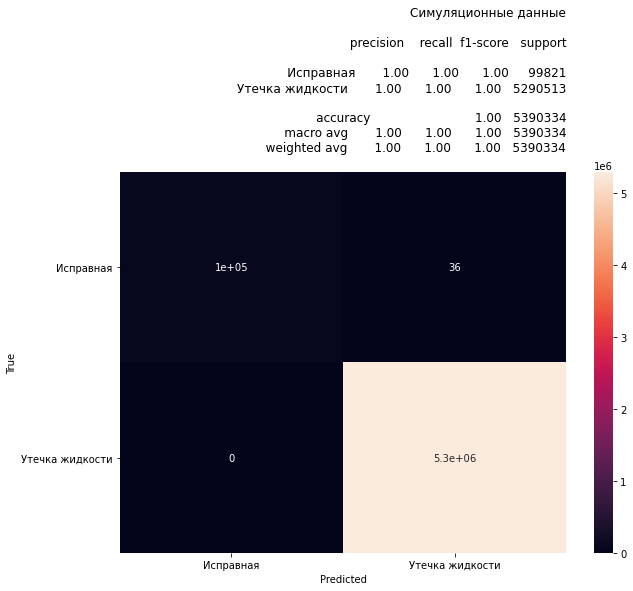

In [27]:
cf = confusion_matrix(test_labels_true, test_labels_predicted, normalize=None)

df_cm = pd.DataFrame(cf, index = class_names.values(), columns = class_names.values())

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.ylabel('True')
plt.gca().set_yticklabels(plt.gca().get_yticklabels(), rotation=0)
plt.xlabel('Predicted')
plt.title("Симуляционные данные\n\n" + classification_report(test_labels_true, test_labels_predicted, target_names=class_names.values()), loc="right")

In [29]:
cf = confusion_matrix(experiment_labels_true, experiment_labels_predicted, normalize=None)

df_cm = pd.DataFrame(cf, index = class_names.values(), columns = class_names.values())

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.ylabel('True')
plt.gca().set_yticklabels(plt.gca().get_yticklabels(), rotation=0)
plt.xlabel('Predicted')
plt.title("Экспериментальные данные\n\n" + classification_report(experiment_labels_true, experiment_labels_predicted, target_names=class_names.values()), loc="right")

Text(1.0, 1.0, 'Экспериментальные данные\n\n                 precision    recall  f1-score   support\n\n      Исправная       1.00      1.00      1.00     46972\nУтечка жидкости       1.00      1.00      1.00     20000\n\n       accuracy                           1.00     66972\n      macro avg       1.00      1.00      1.00     66972\n   weighted avg       1.00      1.00      1.00     66972\n')

In [ ]:
embeddings_sim = encoder_model.predict(Xsim_test_classifier.batch(args.batch_size))

In [30]:
scale = 1
f, ax = plt.subplots(1,1, figsize=(8*scale, 8*scale))

for class_label, class_name, class_color in zip(Xsim.class_names.keys(), Xsim.class_names.values(), class_colors):
    x = embeddings_sim[test_labels_true==class_label, 0]
    y = embeddings_sim[test_labels_true==class_label, 1]    
    ax.scatter(x, y, s=1, label=class_name, color=class_color, alpha=1)       
    
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=8, fontsize=18);

In [ ]:
embeddings_exp = encoder_model.predict(Xexp_test_classifier.batch(args.batch_size))

In [31]:
scale = 1
f, ax = plt.subplots(1,1, figsize=(8*scale, 8*scale))

for class_label, class_name, class_color in zip(Xexp.class_names.keys(), Xexp.class_names.values(), class_colors):
    x = embeddings_exp[experiment_labels_true==class_label,0]
    y = embeddings_exp[experiment_labels_true==class_label,1]    
    ax.scatter(x, y, s=1, label=class_name, color=class_color, alpha=1)       
    
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=8, fontsize=18);

In [ ]:
def custom_classification_report(true, predicted, class_names):
    class_labels = sorted(set(true))
    report_rows = []
    for cid in class_labels:
        class_true = true.copy()
        class_true[true!=cid] = 0
        class_true[true==cid] = 1
        class_predicted = predicted.copy()
        class_predicted[predicted!=cid] = 0
        class_predicted[predicted==cid] = 1
        
        accuracy = skmetrics.accuracy_score(class_true, class_predicted)
        balanced_accuracy = skmetrics.balanced_accuracy_score(class_true, class_predicted)
        precision = skmetrics.precision_score(class_true, class_predicted, average='binary')
        recall = skmetrics.recall_score(class_true, class_predicted, average='binary')
        f1 = skmetrics.f1_score(class_true, class_predicted, average='binary')
        mcc = skmetrics.matthews_corrcoef(class_true, class_predicted)
        report_rows.append([accuracy*100, balanced_accuracy*100, precision, recall, f1, mcc])
    
    accuracy = skmetrics.accuracy_score(true, predicted)
    balanced_accuracy = skmetrics.balanced_accuracy_score(true, predicted)
    precision = skmetrics.precision_score(true, predicted, average='macro')
    recall = skmetrics.recall_score(true, predicted, average='macro')
    f1 = skmetrics.f1_score(true, predicted, average='macro')
    mcc = skmetrics.matthews_corrcoef(true, predicted)
    report_rows.append([accuracy*100, balanced_accuracy*100, precision, recall, f1, mcc])
    
    report = pd.DataFrame(
        report_rows, 
        columns=['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1', 'MCC'],
        index=class_names + ['Total'] )
    
    return report

In [ ]:
%%time
custom_classification_report(test_labels_true, test_labels_predicted, class_names=list(class_names.values()))

In [ ]:
%%time
custom_classification_report(experiment_labels_true, experiment_labels_predicted, class_names=list(class_names.values()))